## Laboratorio di Simulazione Numerica 

# ESERCITAZIONE 10 #

### esercizio 10.1

In questo esercizio abbiamo risolto il problema del commesso viaggiatore (TSP) adattando il codice genetico scritto nell'esercitazione 9 ad un algoritmo di Simulated Annealing (SA).
Analogamente all'esercitazioe 9 abbbiamo affrontato sia la configurazione delle città sulla circonferenza che quella dentro il quadrato.

Il SA si basa su una analogia con la termodinamica, secondo la quale per un sistema che viene raffreddato lentamente la natura è in grado di trovare il minimo dell'energia. L'idea è quindi quella di interpretare la funzione costo $L(x)$ come l'energia di un sistema meccanico-statistico e di considerare la distribuzione di Boltzmann $p(x) = \exp[-\beta L(x)]/Z$. Nel limite di bassa temperatura la distribuzione diventa concentrata intorno al minimo di $L(x)$.
Nel SA pertanto si fa lentamente decrescere la temperatura con l'aumentare degli step della simulazione.
Non abbiamo più lavorato con una popolazione di percorsi, ma con un singolo percorso $\vec{x}$ , all'inizio generato randomicamente. Abbiamo riutilizzato le tre funzioni di mutazione implementate nell'esercitazione precedente, e cioè:
- pair permut: scambia in modo random due città di uno stesso percorso (esclusa la prima).
- m_permut: scambia m città contigue (esclusa la prima e con $m<N/2$) con altre m città tra loro contigue.
- inversion: seleziona m città contigue (esclusa la prima e con $m<N$) e inverte l'ordine in cui sono poste.

Il percorso viene fatto evolvere applicandogli a turno tutte e tre le mutazioni, generando così una proposta di nuovo percorso $\vec{x'}$. $\vec{x'}$ rimpiazza $\vec{x}$ con la seguente probabilità:
- $p(x) = \exp[-\beta (L(\vec{x'})-L(\vec{x}))]$ se $L(\vec{x'}) > L(\vec{x'})$
- $p(x) = 1$ altrimenti

dove $\beta$ è l'inverso della temperatura $T$ a cui si trova il sistema meccanico-statistico.

Per la configurazione a cerchio siamo partiti da una temperatura $T=10.0 K$, per poi decrescere fino a $T=0$ a step di $\Delta T = 0.01 K$. Per ogni temperatura abbiamo per 100 volte tentato di evolvere il percorso applicandogli le tre mutazioni, nella modalità di cui sopra.

Per la configurazione a quadrato abbiamo mantenuto lo stesso procedimento e gli stessi parametri, fatto salvo l'ampiezza degli step, in questo caso di $\Delta T = 0.001 K$

Riportiamo di seguito i risultati per le due simulazioni. In entrambe le configurazioni si tratta di due diversi grafici. Il primo rappresenta la lunghezza del percorso in funzione del passo di iterazione della simulazione. Il secondo è la rappresentazione del miglior percorso ottenuto.




#### città sulla circonferenza

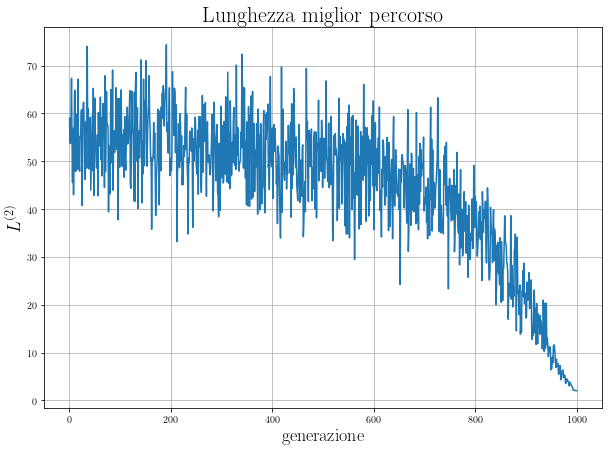

Percorso migliore =  2.03705


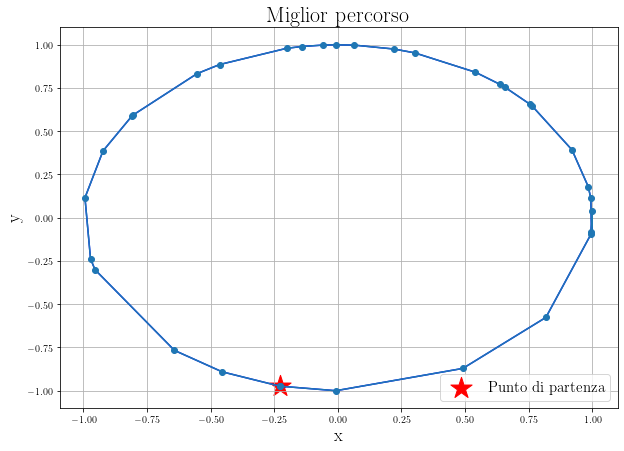

In [6]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

plt.rc('text', usetex=True)
plt.rc('font', family='arial')

## L miglior percorso
x, f = np.loadtxt("L2_circle.txt", usecols=(0,1), unpack='true',  delimiter=',')

plt.figure(figsize=(10, 7))
plt.plot(x,f)
plt.xlabel('generazione', fontsize=18)
plt.ylabel('$L^{(2)}$', fontsize=18)
plt.title("Lunghezza miglior percorso", fontsize=22)
plt.grid(True)
plt.show()

print('Percorso migliore = ', f[-1])

##miglior percorso
plt.figure(figsize=(10, 7))
x, f = np.loadtxt("path_circle.txt", usecols=(0,1), unpack='true',  delimiter=',')

plt.plot(x,f, 'b')
plt.plot(x,f, marker='o')
plt.scatter(x[0], f[0], c='r', marker='*', s=500, label='Punto di partenza')
plt.title('Miglior percorso', fontsize=22)
plt.legend(loc='best', fontsize=15)
plt.xlabel('x', fontsize=18)
plt.ylabel('y', fontsize=18)
plt.grid(True)
plt.show()


#### città dentro il quadrato

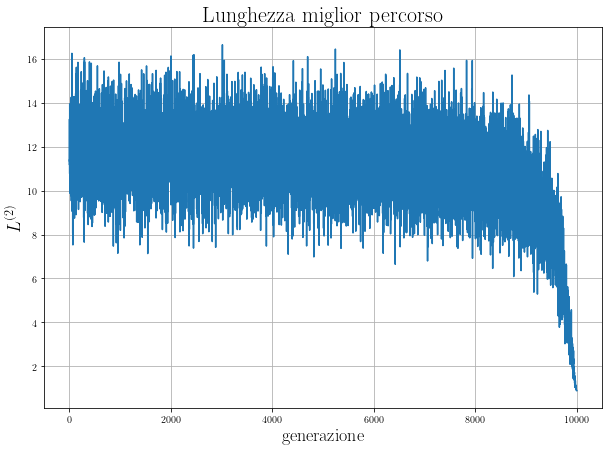

Percorso migliore =  0.882993


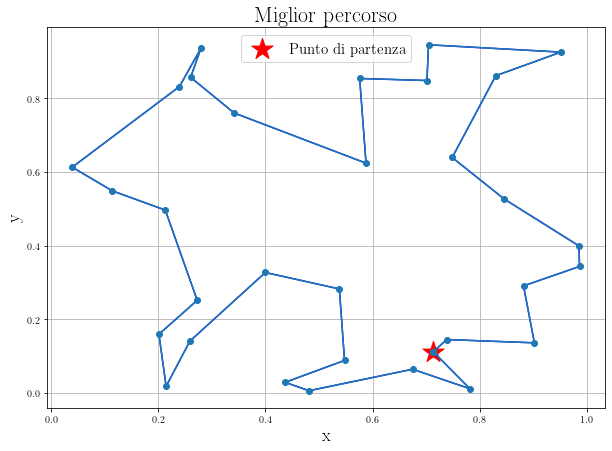

In [7]:
## L miglior percorso
x, f = np.loadtxt("L2_square.txt", usecols=(0,1), unpack='true',  delimiter=',')

plt.figure(figsize=(10, 7))
plt.plot(x,f)
plt.xlabel('generazione', fontsize=18)
plt.ylabel('$L^{(2)}$', fontsize=18)
plt.title("Lunghezza miglior percorso", fontsize=22)
plt.grid(True)
plt.show()

print('Percorso migliore = ', f[-1])

##miglior percorso
plt.figure(figsize=(10, 7))
x, f = np.loadtxt("path_square.txt", usecols=(0,1), unpack='true',  delimiter=',')

plt.plot(x,f, 'b')
plt.plot(x,f, marker='o')
plt.scatter(x[0], f[0], c='r', marker='*', s=500, label='Punto di partenza')
plt.title('Miglior percorso', fontsize=22)
plt.legend(loc='best', fontsize=15)
plt.xlabel('x', fontsize=18)
plt.ylabel('y', fontsize=18)
plt.grid(True)
plt.show()


### esercizio 10.1

In questo esercizio abbiamo nuovamente risolto il TSP facendo uso dell'algoritmo genetico, sfruttando però la computazione parallela. Grazie alla libreria MPI abbiamo implementato 4 ricerche parallelle del miglior percorso: ogni nodo ha sviluppato un GA indipendente, chiamato continente. Tuttavia, ogni $N_{migr}$ generazioni, i continenti si scambiavano randomicamente i rispettivi migliori percorsi delle loro correnti popolazioni.

Per fare ciò abbiamo apportato alcune modifiche al codice sviluppato nell'esercitazione 9.
Per prima cosa abbiamo sdoppiato il generatore di numeri casuali, creando i due generatori my_rand e my_rand0. La differenza tra i due consiste nell'inizializzazione: my_rand0 è comunque a tutti i nodi, mentre my_rand è specifico per ciascuno, è stato inizializzato con semi diversi. Questa differenzazione è legata alla necessità di avere delle variabili che, seppur randomiche, devono essere comuni a tutti i diversi continenti, ma anche al fatto che ci sono determinati processi che se non vengono svolti diversamente da continente a continente vanificano il senso dell'esercizio. Ecco pertanto che le posizioni delle diverse città e le coppie di continenti che si devono scambiare le informazioni ogni $N_{migr}$ sono state generate in maniera comune con my_rand0, mentre tutte le componenenti dell'evoluzione genetica della popolazione (come il crossover e le mutazioni) usano my_rand.

Come detto, ogni $N_{migr}$ i continenti si scambiano delle informazioni. Per fare questo abbiamo utilizzato le funzioni MPI_Send e MPI_Recv, che sono dell funzioni di MPI bloccanti per ogni processo.

Nell'esercizio era richiesto solo di risolvere il TSP per la configurazione a quadrato.
I valori dei parametri sono:
- $r=2$
- $NN=500$
- probabilità di crossing: $55%$
- probabilità di mutazione: $10%$
- generazioni: $300$
- $N_{migr} = 25$

Sono gli stessi parametri utilizzati nell'esercitazione 9, eccezion fatta per il numero di generazioni, dal momento che, come sarà visibile nei risultati, è stato sufficiente un numero minore di cicli per ottimizzare il percorso. Anche le posizioni delle città sono le stesse dell'esercitazione precedente, in questo modo è stato possibile fare un confronto tra il GA e il GA provvisto di computazione parallela.

Riportiamo di seguito i risultati ottenuti, sotto forma di tre grafici per ogni continente. Il primo rappresenta il valore di $L^{(2)}$ del miglior percorso della popolazione in funzione delle generazioni. Il secondo il valore medio di $L^{(2)}$ (mediato sulla miglior metà della popolazione) in funzione del generazioni. Il terzo il miglior percorso ottenuto al termine dell simulazione.

##### continente0

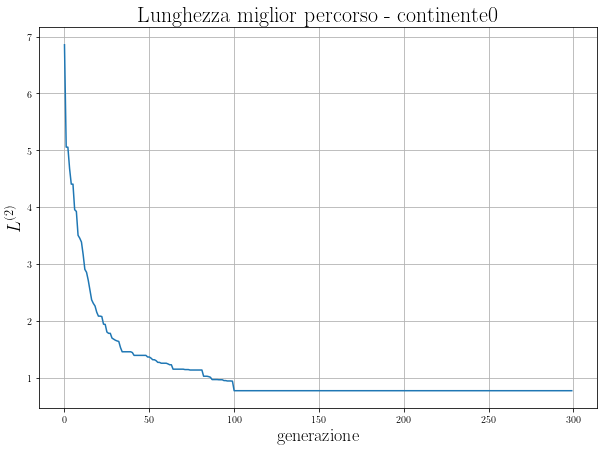

Percorso migliore =  0.767958


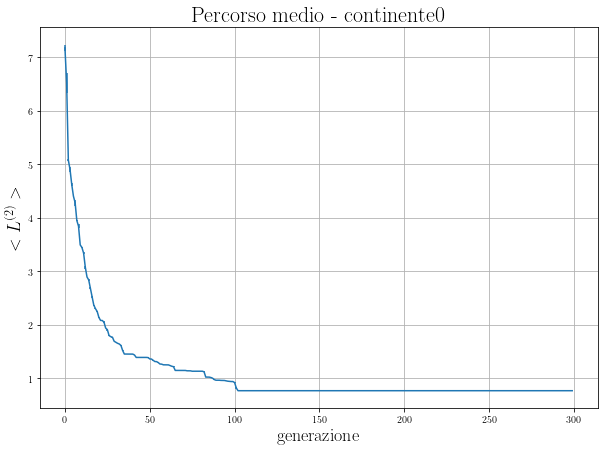

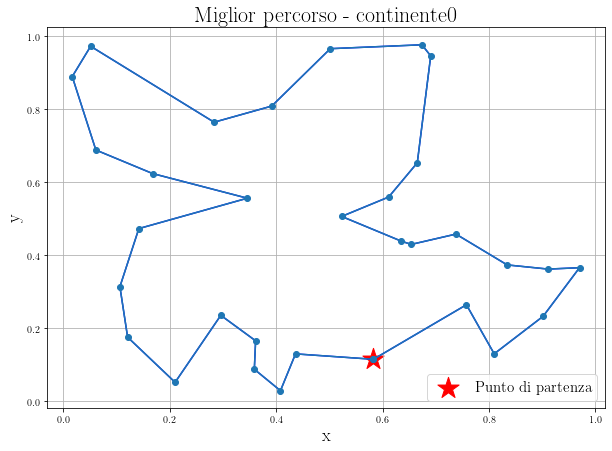

In [12]:
## L miglior percorso
x, f = np.loadtxt("L2_squarerk0.txt", usecols=(0,1), unpack='true',  delimiter=',')

plt.figure(figsize=(10, 7))
plt.plot(x,f)
plt.xlabel('generazione', fontsize=18)
plt.ylabel('$L^{(2)}$', fontsize=18)
plt.title("Lunghezza miglior percorso - continente0", fontsize=22)
plt.grid(True)
plt.show()

print('Percorso migliore = ', f[-1])

##valore medio
plt.figure(figsize=(10, 7))
x, f, error = np.loadtxt("ave_squarerk0.txt", usecols=(0,1,2), delimiter=', ', unpack='true')
plt.errorbar(x,f ,yerr=error)

plt.xlabel('generazione', fontsize=18)
plt.ylabel('$<L^{(2)}>$', fontsize=18)
plt.title("Percorso medio - continente0 ", fontsize=22)
plt.grid(True)
plt.show()

##miglior percorso
plt.figure(figsize=(10, 7))
x, f = np.loadtxt("path_squarerk0.txt", usecols=(0,1), unpack='true',  delimiter=',')

plt.plot(x,f, 'b')
plt.plot(x,f, marker='o')
plt.scatter(x[0], f[0], c='r', marker='*', s=500, label='Punto di partenza')
plt.title('Miglior percorso - continente0', fontsize=22)
plt.legend(loc='best', fontsize=15)
plt.xlabel('x', fontsize=18)
plt.ylabel('y', fontsize=18)
plt.grid(True)
plt.show()

##### continente1

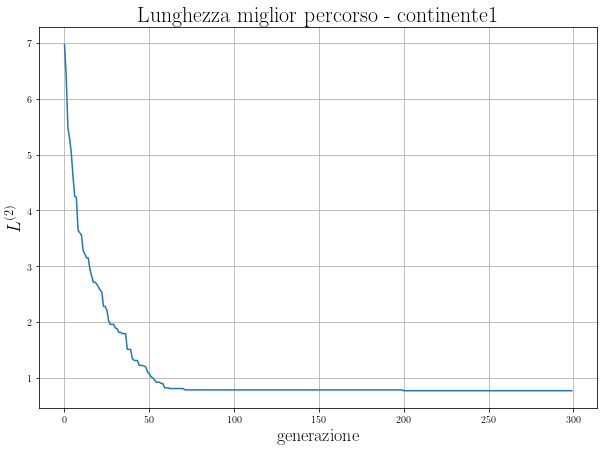

Percorso migliore =  0.767958


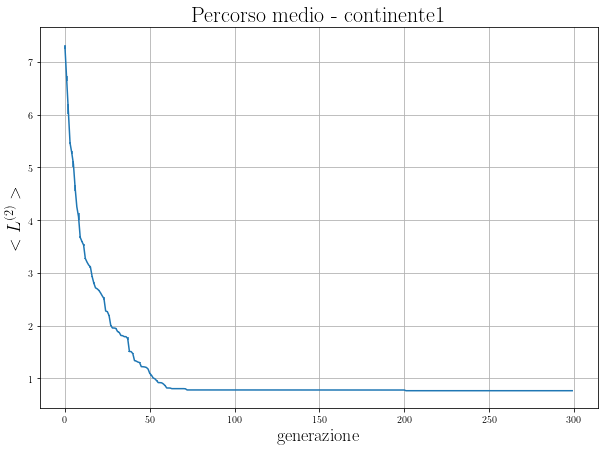

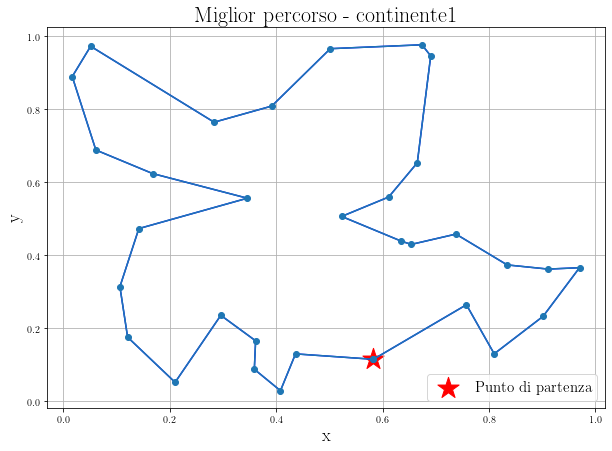

In [13]:
## L miglior percorso
x, f = np.loadtxt("L2_squarerk1.txt", usecols=(0,1), unpack='true',  delimiter=',')

plt.figure(figsize=(10, 7))
plt.plot(x,f)
plt.xlabel('generazione', fontsize=18)
plt.ylabel('$L^{(2)}$', fontsize=18)
plt.title("Lunghezza miglior percorso - continente1", fontsize=22)
plt.grid(True)
plt.show()

print('Percorso migliore = ', f[-1])

##valore medio
plt.figure(figsize=(10, 7))
x, f, error = np.loadtxt("ave_squarerk1.txt", usecols=(0,1,2), delimiter=', ', unpack='true')
plt.errorbar(x,f ,yerr=error)

plt.xlabel('generazione', fontsize=18)
plt.ylabel('$<L^{(2)}>$', fontsize=18)
plt.title("Percorso medio - continente1 ", fontsize=22)
plt.grid(True)
plt.show()

##miglior percorso
plt.figure(figsize=(10, 7))
x, f = np.loadtxt("path_squarerk1.txt", usecols=(0,1), unpack='true',  delimiter=',')

plt.plot(x,f, 'b')
plt.plot(x,f, marker='o')
plt.scatter(x[0], f[0], c='r', marker='*', s=500, label='Punto di partenza')
plt.title('Miglior percorso - continente1', fontsize=22)
plt.legend(loc='best', fontsize=15)
plt.xlabel('x', fontsize=18)
plt.ylabel('y', fontsize=18)
plt.grid(True)
plt.show()

##### continente2

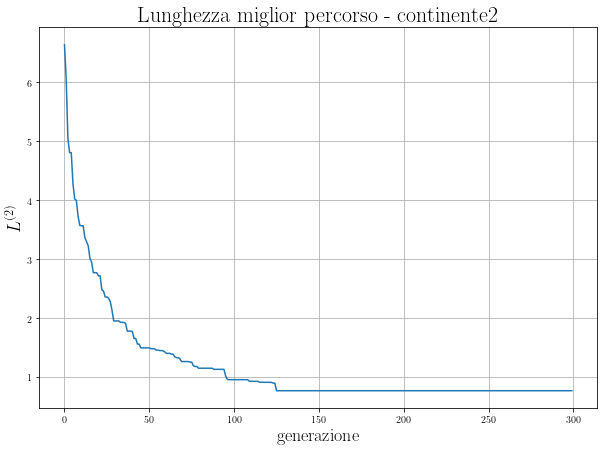

Percorso migliore =  0.767958


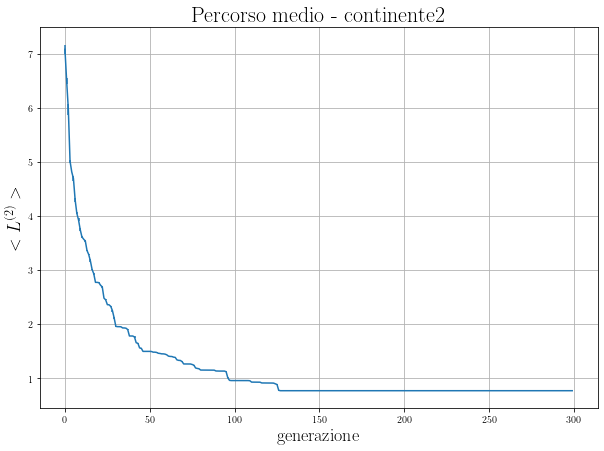

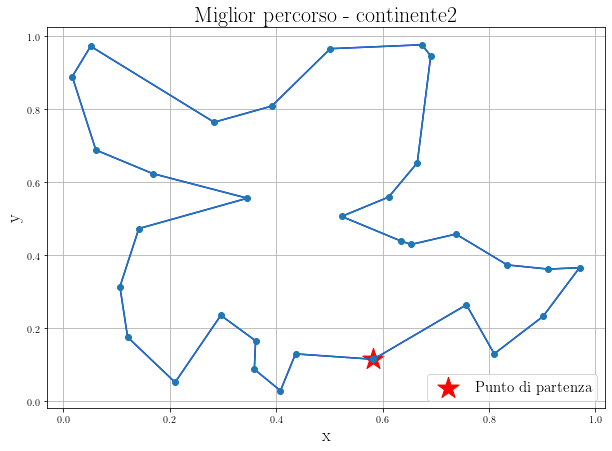

In [14]:
## L miglior percorso
x, f = np.loadtxt("L2_squarerk2.txt", usecols=(0,1), unpack='true',  delimiter=',')

plt.figure(figsize=(10, 7))
plt.plot(x,f)
plt.xlabel('generazione', fontsize=18)
plt.ylabel('$L^{(2)}$', fontsize=18)
plt.title("Lunghezza miglior percorso - continente2", fontsize=22)
plt.grid(True)
plt.show()

print('Percorso migliore = ', f[-1])

##valore medio
plt.figure(figsize=(10, 7))
x, f, error = np.loadtxt("ave_squarerk2.txt", usecols=(0,1,2), delimiter=', ', unpack='true')
plt.errorbar(x,f ,yerr=error)

plt.xlabel('generazione', fontsize=18)
plt.ylabel('$<L^{(2)}>$', fontsize=18)
plt.title("Percorso medio - continente2 ", fontsize=22)
plt.grid(True)
plt.show()

##miglior percorso
plt.figure(figsize=(10, 7))
x, f = np.loadtxt("path_squarerk2.txt", usecols=(0,1), unpack='true',  delimiter=',')

plt.plot(x,f, 'b')
plt.plot(x,f, marker='o')
plt.scatter(x[0], f[0], c='r', marker='*', s=500, label='Punto di partenza')
plt.title('Miglior percorso - continente2', fontsize=22)
plt.legend(loc='best', fontsize=15)
plt.xlabel('x', fontsize=18)
plt.ylabel('y', fontsize=18)
plt.grid(True)
plt.show()

##### continente3

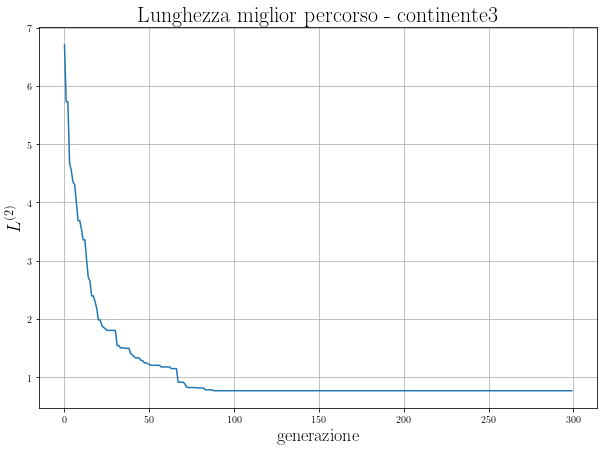

Percorso migliore =  0.767958


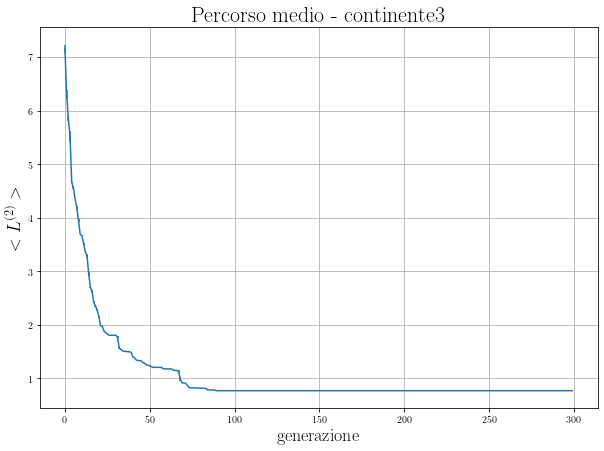

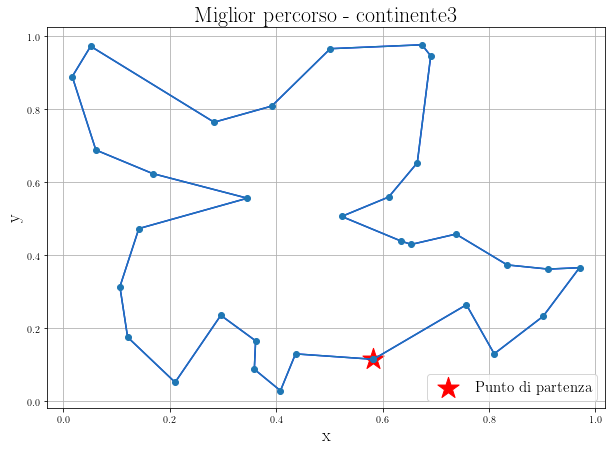

In [15]:
## L miglior percorso
x, f = np.loadtxt("L2_squarerk3.txt", usecols=(0,1), unpack='true',  delimiter=',')

plt.figure(figsize=(10, 7))
plt.plot(x,f)
plt.xlabel('generazione', fontsize=18)
plt.ylabel('$L^{(2)}$', fontsize=18)
plt.title("Lunghezza miglior percorso - continente3", fontsize=22)
plt.grid(True)
plt.show()

print('Percorso migliore = ', f[-1])

##valore medio
plt.figure(figsize=(10, 7))
x, f, error = np.loadtxt("ave_squarerk3.txt", usecols=(0,1,2), delimiter=', ', unpack='true')
plt.errorbar(x,f ,yerr=error)

plt.xlabel('generazione', fontsize=18)
plt.ylabel('$<L^{(2)}>$', fontsize=18)
plt.title("Percorso medio - continente3 ", fontsize=22)
plt.grid(True)
plt.show()

##miglior percorso
plt.figure(figsize=(10, 7))
x, f = np.loadtxt("path_squarerk3.txt", usecols=(0,1), unpack='true',  delimiter=',')

plt.plot(x,f, 'b')
plt.plot(x,f, marker='o')
plt.scatter(x[0], f[0], c='r', marker='*', s=500, label='Punto di partenza')
plt.title('Miglior percorso - continente3', fontsize=22)
plt.legend(loc='best', fontsize=15)
plt.xlabel('x', fontsize=18)
plt.ylabel('y', fontsize=18)
plt.grid(True)
plt.show()

Si può notare come tutti i continenti, seppure con tempistiche leggermente differenti, convergano alla stessa configurazione finale. I nodi 2 e 3 addirittura in meno di 100 generazioni, mentre i nodi 0 e 1 di poco oltre le 100. Tutti i nodi comunque mostrano una convergenza migliore di quanto non fosse quella del GA nell'esercizio 9.1. Infatti, per quanto sembri che anche nel precedente esercizio la convergenza sopraggiunga poco dopo le 100 generazioni, il percorso trovato in quel punto non rappresentava il migliore possibile, dal momento che la sua lunghezza risultava, seppur di poco, maggiore di quella trovata nell'esercizio 10.2. Come già accennato nel commento all'esercizio 9.1, aumentando il numero di generazioni è possibile osservare il raggiungimento dello stesso miglior percorso trovato in questo esercizio, tuttavia solo intorno alla generazione 400.

